In [1]:
from tensorflow.keras.models import load_model

import numpy as np
from tensorflow.image import extract_patches
import rasterio
import tensorflow as tf

In [2]:
# List available physical devices and check for GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

if physical_devices:
    # Set memory growth to prevent memory allocation issues
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected. Using CPU.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
model_path="output/model/lstm_mul_model_eaton.h5"
model = load_model(model_path)
sar_image_path="output/sar/3_eaton_s1_mul_ready.tif"


2025-04-02 18:57:27.036845: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-02 18:57:27.036869: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-02 18:57:27.036876: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-02 18:57:27.036912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-02 18:57:27.036931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import numpy as np

def create_patch(data_set, patch_size=5):
    """
    Creates a patch for every pixel in the dataset.
    
    Parameters:
    data_set (numpy array): 3D NumPy array representing the dataset (rows, cols, bands).
    patch_size (int): Size of the square patch (default: 5).
    
    Returns:
    numpy array: 4D array of shape (rows * cols, patch_size, patch_size, bands).
    """
    rows, cols, bands = data_set.shape
    max_row, max_col = rows - 1, cols - 1
    
    # Initialize the output tensor
    input_tensor = np.zeros((rows * cols, patch_size, patch_size, bands))
    
    # Iterate over each pixel to create patches
    index = 0
    for row in range(rows):
        for col in range(cols):
            patch = np.zeros((patch_size, patch_size, bands))
            patch_top_row = row - patch_size // 2
            patch_left_col = col - patch_size // 2
            
            for i in range(patch_size):
                for j in range(patch_size):
                    patch_row = patch_top_row + i
                    patch_col = patch_left_col + j
                    
                    # Ensure the indices are within the valid range
                    if 0 <= patch_row <= max_row and 0 <= patch_col <= max_col:
                        patch[i, j, :] = data_set[patch_row, patch_col, :]
            
            input_tensor[index] = patch
            index += 1
    
    return input_tensor

In [5]:
with rasterio.open(sar_image_path) as dataset:
    data_set = dataset.read([1,2,3,4]) 
    data_set = np.transpose(data_set, (1, 2, 0))

In [11]:
width,height,_=data_set.shape

In [6]:

input_tensor=create_patch(data_set, patch_size=5)

In [7]:
predictions = model.predict(input_tensor)

2025-04-02 19:05:20.623328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-02 19:05:20.709013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-02 19:05:20.954585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-02 19:05:21.018499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


68341/68341 [==============================] - 214s 3ms/step


In [12]:
# predictions
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
predicted_map = predicted_labels.reshape(width, height)

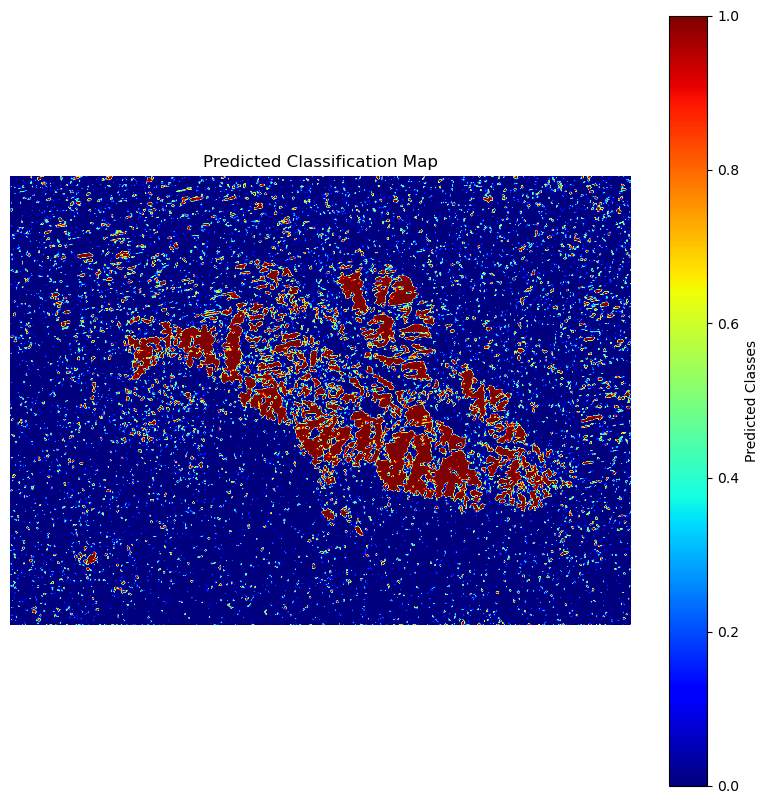

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(predicted_map, cmap='jet')  # Use a colormap that highlights classes
plt.colorbar(label="Predicted Classes")
plt.title("Predicted Classification Map")
plt.axis("off")
plt.show()


In [19]:
import tifffile as tiff
# Save as TIFF
tiff.imwrite("output/prediction/lstm_eaton.tif", predicted_map.astype(np.float32))